# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

---

There are 2 types of tasks in this assignment:
- coding tasks --- asking you to write code following specifications provided; Most of the tasks come with test cases for sanity-check. Still, if something is not clear, <ins>do ask questions to lab teachers</ins>.
- interpretation questions --- asking you to interpret the data or the results of the model

Each comes with its predefined points (totaling to 16pt). Some coding tasks have 0 points but solving them will be useful for you.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily means that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debuging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>


# <font color="red">Contributions</font>

* Students:
**  Riccardo Campanella
**  Samuele Milanese
**  Ettore Cesari

*  We all worked on all exercises together

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics.

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word.

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">he</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, you might find the [fandom page](https://harrypotter.fandom.com/wiki/Main_Page) useful or the [synopsis sections](https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone) of the corresponding wiki pages.

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 124, "said": 114, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 124 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [ ]:
import pickle
import torch
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List
# torch.set_printoptions(precision=8) #to increase precision of printing floats

In [ ]:
# this command downloads the pickle file.
# This is not a python code, it is a unix code. You can run system commands in jupyter notebooks.
!wget -nv -O HP-Counts.p https://www.dropbox.com/scl/fi/dnm7s38j8d0k0bguisiby/HP-Counts.p?rlkey=j0fc11rlnkow7jqb02sel6gz6&dl=1
# try this if download from the dropbox link doesn't work
# !wget -nv -O HP-Counts.p https://naturallogic.pro/_files_/download/MLHVL/HP-Counts.p

2023-10-31 15:40:35 URL:https://uc420f68a66a04ba838d7e189c37.dl.dropboxusercontent.com/cd/0/inline/CGqxBBuez8vogFEDBnjbxKVXk7-JSwwcy0RTP2iMK3lQ_c3RPo5k4JXyeQ2njeIPeEh6ohVFvc4AKWVspYH1xGyv1lxyVSRYB3eGrp9RxhbQyM0skhRFPnqKHlqQhIjnV7g/file [173580603/173580603] -> "HP-Counts.p" [1]


In [ ]:
with open("HP-Counts.p", "rb") as f:
    vocab, contexts, X = pickle.load(f)

Let's inspect the top 10 most frequent words in the context of the word 'portrait'.

In [ ]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)[:10]

[('harry', 124),
 ('said', 114),
 ('hole', 85),
 ('ron', 57),
 ('hermione', 54),
 ('room', 48),
 ('fat', 45),
 ('lady', 43),
 ('common', 37),
 ('back', 31)]

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content.

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### From co-occurrence to probabilities

Our matrix $X$ is very sparse; most of its elements are zero.

Find what the ratio of non-zero elements is.  
Check if the matrix is symmetric (think about why it should (not) be).

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [ ]:
# @title c1.1 [0pt]
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
  binary_matrix = torch.where(sparse_matrix > 0, torch.tensor(1), torch.tensor(0))  # Creating a matrix with ones where the condition is satisfied
  non_zero_count = torch.sum(binary_matrix)  # Sum all the value in the matrix to count how many non-zero elements are present
  return (non_zero_count / (sparse_matrix.shape[0] * sparse_matrix.shape[1])).item()

In [ ]:
# TEST c1.1
assert 0.1 < non_zero_ratio(X) < 0.2

We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements.

Change the matrix's datatype to a `torch.float` and add a small constant to it (e.g. $0.1$) to ensure numerical stability while maintaining sparsity. The obtained matrix will be used in the remaining sections (not the original one).

In [ ]:
# @title c1.2 [.25pt]
epsilon = 0.1
X1 = X.to(torch.float) + epsilon

In [ ]:
# TEST c1.2
assert non_zero_ratio(X1) == 1

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

From the paper:
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appears in the context of word $i$.

Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$.

_Hint_: Remember broadcasting and `torch.sum()`.

In [ ]:
# @title c1.3 [.25pt]
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
  return count_matrix / torch.sum(count_matrix, dim=1) # dividing element-wise for sum of elements ina row

In [ ]:
P = to_probabilities(X1) # note that we use X1 not X here

In [ ]:
# TEST c1.3
assert P.shape == torch.Size([len(vocab), len(vocab)])

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$. If such probability is impossible to compute for input words, return float 0. probability.  

In [ ]:
# @title c2.1 [.25pt]
def query(word_i: str, word_j: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
  if word_i in vocab and word_j in vocab:
    return prob_matrix[vocab[word_j]][vocab[word_i]].item()
  return 0.0

In [ ]:
# TEST c2.1
assert round(query('harry', 'potter', vocab, P), 5) == 0.00353

Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$.

In [ ]:
# @title c2.2 [.25pt]
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    q_ik = query(word_i, word_k, vocab, prob_matrix)
    q_jk = query(word_j, word_k, vocab, prob_matrix)
    return q_ik / q_jk

In [ ]:
# TEST c2.2
assert round(probe('harry', 'potter', 'stone', vocab, P), 4) == 1.3872

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. **Add two pairs of your own word triplets** and experiment on them.

In [ ]:
print("tea", "wand", "magic", probe("tea", "wand", "magic", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()

# YOUR CODE HERE
print("horcrux", "basilisk", "voldemort", probe("horcrux", "basilisk", "voldemort", vocab, P)) #voldermort is related to horcrux and not to basilisk
print("horcruxes", "basilisk", "voldemort", probe("horcruxes", "basilisk", "voldemort", vocab, P)) #voldermort is related to horcruxes and not to basilisk
print("ron", "hermione", "harry", probe("ron", "hermione", "harry", vocab, P)) #voldemort is related to either horcrux and harry


tea wand magic 0.018442942510795767
tea wand cup 26.14265487166853

horcrux basilisk voldemort 9.311100803247067
horcruxes basilisk voldemort 16.74751668378884
ron hermione harry 1.0634629228801569


#### i1 [1pt]
Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

**ANSWER**: When correlating Harry to his friends Hermione and Ron, we expect to see an almost identical value when mesuring the probability of having the word 'harry' in the context of both words because the two characters occur often in the same context throughout the story. The Probing returns 1.06 as value meaning that Harry is slightly more correlated to Ron than to Hermione though in general we can say there is no evident prevalence. Technically, when probing, the probability that the word 'ron' is predicted by the word 'harry' (the numerator) is almost identical to the probability that the word 'hermione' is predicted by the word 'harry' (the denominator), thus the ratio is close to 1 and we conclude that 'harry' is not a good discriminator word.

The correlation between Voldemort and horcrux is expected to be higher. Since horcruxes are objects created by Voldemort and used by him to preserve his soul throughout the whole saga, it's natural to have them near to the character who created it, meaning that during the narration both the words are often recurring in the same context. The value is indeed high ($\sim 9.3$). On the contrary, the basilisk is not directly correlated to Voldemort and appears in its context much less and also only in one book. Moreover, since the horcruxes are more than one, in the story they are usually referred in the plural form. As a matter of fact, when probing horcruxes in the plural form, the value is even higher ($\sim 16.7)$

What would happen if we tried probing out-of-domain words? Use the words that the authors report in the paper in the context of "ice" and "steam" (Table 1). Make your code to clearly print the details.

In [ ]:
# YOUR CODE HERE
print("ice", "steam", "solid", probe("ice", "steam", "solid", vocab, P))
print("ice", "steam", "gas", probe("ice", "steam", "gas", vocab, P))
print("ice", "steam", "water", probe("ice", "steam", "water", vocab, P))
print("ice", "steam", "fashion", probe("ice", "steam", "fashion", vocab, P))

ice steam solid 0.07830312620153405
ice steam gas 0.8613343808912856
ice steam water 1.27149363325054
ice steam fashion 0.8613343808912856


#### i2 [1pt]
Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

**ANSWER**: When probing for the (out of domain) words ice and steam we obtain results that match with what the authors report in the paper. The last two probes, water and fashion, have values close to 1 as they are either related to both or to none. When probing for solid we obtain a very low value as expected as this word relates to ice but not steam. When probing gas, on the other hand, we obtain the same value as for fashion. This shows that gas appears in the context of steam and ice as much as fashion which highlights the inadequacy of the corpus for these specific words.

## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones.

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as

$f: \mathbb{R} \to \mathbb{R} = \begin{cases}
    (x/x_{max})^\alpha, & \text{if $x<x_{max}$}\\
    1, & \text{otherwise}.
  \end{cases}$

### Weighting Function

Let's start with the last part.

Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X_weighted}$, the matrix ${X}$ after weighting, using the paper's suggested parameters.

_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise.

In [ ]:
# @title c3 [.25pt]
def weight_fn(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
    return torch.where(X < x_max, (X/x_max)**alpha, 1)

In [ ]:
X_weighted = weight_fn(X1, x_max=100, alpha=3/4)

In [ ]:
# TEST c3
assert X_weighted.shape == X1.shape

Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X_weighted}$ to get a better idea.

In [ ]:
# YOUR CODE HERE
print('X: ', X1[vocab['harry'], vocab['potter']].item(), 'X_weighted: ', X_weighted[vocab['harry'], vocab['potter']].item())
print('X: ', X1[vocab['wand'], vocab['magic']].item(), 'X_weighted: ', X_weighted[vocab['wand'], vocab['magic']].item())
print('X: ', X1[vocab['steam'], vocab['magic']].item(), 'X_weighted: ', X_weighted[vocab['steam'], vocab['magic']].item())

X:  1485.0999755859375 X_weighted:  1.0
X:  56.099998474121094 X_weighted:  0.6482195854187012
X:  0.10000000149011612 X_weighted:  0.005623413249850273


### Loss Function

The next step is to write the loss function.

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient.

Inspecting the formulation of $J$, it is fairly straightforward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$.

In [ ]:
# @title c4 [.25pt]
def loss_fn(
    X_weighted: FloatTensor,
    W: FloatTensor,
    W_context: FloatTensor,
    B: FloatTensor,
    B_context: FloatTensor,
    X: FloatTensor
) -> FloatTensor:
    return torch.sum(X_weighted * (W@W_context.transpose(1,0) + B + B_context.transpose(1,0) - torch.log(X))**2)

Let's make sure that we are on a right track. For this we calculate the loss function with toy input: matrices are of size $2 \times 2$ while bias vectors of size $2 \times 1$. You can verify the answer manually and with your implementation of `loss_fn`.

In [ ]:
# TEST c4
toy_X_weighted = torch.FloatTensor([[.5,1],[.2,.1]])
toy_X1 = torch.FloatTensor([[2,1],[1,5]])
toy_W1 = torch.FloatTensor([[1,2],[1,0]]) # for W
toy_W2 = torch.FloatTensor([[0,1],[1,2]]) # for W~
toy_b1 = torch.FloatTensor([[0],[2]]) # for b
toy_b2 = torch.FloatTensor([[2],[1]]) # for b~
# fill the correct value
assert loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1).isclose(FloatTensor([45.239]))

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors.

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. It is recommended to read about Embedding class  

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [ ]:
# @title c5 [1.5pt]
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu", seed: int=0) -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        torch.manual_seed(seed) #random initialization of w, wc, b, bc is fixed by the seed
        self.w = torch.nn.Embedding(self.vocab_len, vector_dim, device=self.device)
        self.wc = torch.nn.Embedding(self.vocab_len, vector_dim, device=self.device)
        self.b = torch.nn.Embedding(self.vocab_len, 1, device=self.device)
        self.bc = torch.nn.Embedding(self.vocab_len, 1, device=self.device)

    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        WC = self.wc(embedding_input)
        B = self.b(embedding_input)
        BC = self.bc(embedding_input)
        return loss_fn(X_weighted, W, WC, B, BC, X)

    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        WC = self.wc(embedding_input)
        return W + WC

In [ ]:
# TEST c5
assert GloVe(vocab, vector_dim=30, seed=0).w.num_embeddings == len(vocab)
assert GloVe(vocab, vector_dim=30, seed=0).bc.num_embeddings == len(vocab)

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign).

Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs (don't change the default seed value).

When writing the training script, remember that your network's forward pass is __already__ computing the loss. Make sure to print a loss value for each epoch.

Training won't take too long on a CPU. In case you want to use a GPU, make sure that variables are correctly moved to a GPU with a `device` argument of class `GloVe`.

In [ ]:
# @title c6.1 [1pt]
network = GloVe(vocab, vector_dim=30)
opt = torch.optim.Adam(torch.nn.ModuleList([network.w, network.wc, network.b, network.bc]).parameters(), lr=0.05) # giving all parameters to optimizer

In [ ]:
%%time
num_epochs = 300
losses = [] # collect losses for each epoch here
for i in range(num_epochs):
    loss = network(X_weighted, X1) # loss computation
    losses.append(loss)
    loss.backward() # gradient computation
    opt.step() # back-propagation
    opt.zero_grad() # gradient reset

CPU times: user 1min 14s, sys: 2min, total: 3min 14s
Wall time: 3min 15s


Note that if you want to re-run the training process from scratch, remember that you also need to redefine `network` otherwise your training will continue from the last epoch's training state.  
<font color="red">**Don't clear the output of the above cell!**</font>

In [ ]:
# TEST c6.1
assert len(losses) == 300
assert losses[0] > losses[-1]

Plot the losses (x axis for epoch number and y axis for loss) and examine the learning curve. Ask yourself, is its shape what you would expect it to be?

Text(0, 0.5, 'loss')

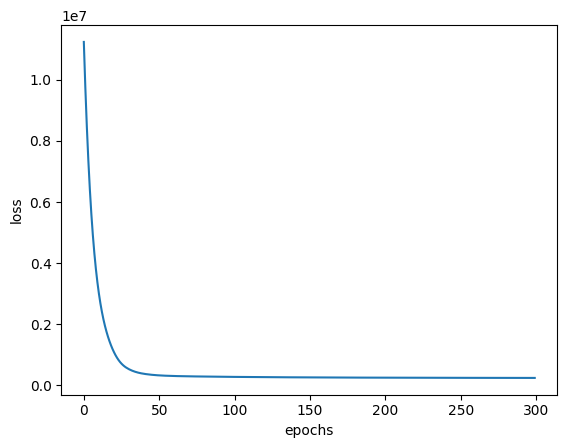

In [ ]:
# @title c6.2 [0pt]
# YOUR CODE HERE
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), [l.item() for l in losses])
plt.xlabel('epochs')
plt.ylabel('loss')

<font color="red">**Don't clear the output of the above cell!**</font>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment.

We will check which words the model considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high-dimensional vector spaces is the cosine similarity.

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words. For an outside-vocabulary word similarity is 0.

In [ ]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    if not(word_i in vocab and word_i in vocab): return 0.
    i = vocab[word_i]
    j = vocab[word_j]
    v_i = vectors[i] / torch.linalg.vector_norm(vectors[i])  # a/|a|
    v_j = vectors[j] / torch.linalg.vector_norm(vectors[j])  # b/|b|
    sim = torch.mm(v_i.view(1, -1), v_j.view(-1, 1)).item()
    # sim = sim = torch.dot(v_i, v_j)
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs if it helps to support your answer:

In [ ]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"),
    ("avada", "kedavra"),
    ("hogwarts", "school"),
    ("goblin", "hagrid"),
    ("giant", "hagrid"),
]:
    print(f"Similarity between '{pair[0]}' and '{pair[1]}' is: {similarity(pair[0], pair[1], vocab, word_vectors)}")

Similarity between 'cruciatus' and 'imperius' is: 0.49876075983047485
Similarity between 'avada' and 'kedavra' is: 0.6552067995071411
Similarity between 'hogwarts' and 'school' is: 0.7654938101768494
Similarity between 'goblin' and 'hagrid' is: 0.27460339665412903
Similarity between 'giant' and 'hagrid' is: 0.5027311444282532


#### i3 [1pt]
Give an interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

**ANSWER**: The best example is represented by 'hogwarts' and 'school'. There is a IS-A relationship between the first and the latter word, hence they are interchangeable in the context. This is reflected by the high similarity score. Also 'cruciatus' and 'imperius' are interchangeable as they are the same type of entity (they're both "spells"). We expected similarity to be higher, but the network still captured that they are related. 'avada' and 'kedavra' on the other hand, are not interchangeable but appear together throughout the whole series, thus it could be expected that their similarity score would be high. Finally, the model captures well the meaning of the word 'hagrid' as it is more similar to 'giant' than 'goblin'. These are both fantastic creatures, but Hagrid is a half-giant and not a goblin.

To obtain the similarities of one word against all other words in the corpus, use torch functions and follow the equation ($\vec{c}_i$ is $i$th row of $\mathbf{C}$):
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2} = \Big(\frac{\vec{w}\cdot \vec{c}_1}{|\vec{w}|_2 \cdot |\vec{c}_1|_2},\ldots,\frac{\vec{w}\cdot \vec{c}_N}{|\vec{w}|_2 \cdot |\vec{c}_N|_2}\Big)$$

Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus. If a word is out of vocabulary, it should return a matrix of 0 similarities.

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [ ]:
# @title c7 [1.5pt]
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    # use torch functions. Don't iterate over rows of vectors matrix!
    if word_i not in vocab: return torch.zeros(1, len(vocab)) # return empty similarities vector if word is not in vocabulary
    v_i = vectors[vocab[word_i]]
    reg = (torch.linalg.vector_norm(v_i)*torch.linalg.vector_norm(vectors)) # denominator part of the cosine similarity formula
    return torch.sum(v_i*vectors, dim=-1).view(1, -1)/reg # cosine similarity formula between a vector and the matrix

In [ ]:
# TEST c7a
assert similarities('harry', vocab, word_vectors).shape == torch.Size([1, len(vocab)])
assert similarities('cow', vocab, word_vectors).shape == torch.Size([1, len(vocab)])

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [ ]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    """ Returns a list of k words that are most similar to word_i
        The list excludes word_i itself
    """
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k+1)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i][:k]

In [ ]:
# TEST c7b
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print(f"Most similar words to '{word}': {most_similar(word, vocab, word_vectors, 6)}")

Most similar words to 'forbidden': ['cabin', 'forest', 'lawns', 'grounds', 'deeper', 'fer']
Most similar words to 'myrtle': ['bathroom', 'moaning', 'toilet', 'nigellus', 'krum', 'ernie']
Most similar words to 'gryffindor': ['points', 'ravenclaw', 'slytherin', 'hufflepuff', 'wood', 'team']
Most similar words to 'wand': ['could', 'harry', 'face', 'light', 'well', 'head']
Most similar words to 'quidditch': ['team', 'training', 'tournament', 'match', 'seeker', 'oliver']
Most similar words to 'marauder': ['map', 'lady', 'tower', 'eat', 'defense', 'dormitory']
Most similar words to 'horcrux': ['sword', 'goblin', 'locket', 'horcruxes', 'ring', 'griphook']
Most similar words to 'phoenix': ['feather', 'fawkes', 'minister', 'wand', 'ollivander', 'exist']
Most similar words to 'triwizard': ['tournament', 'champions', 'cedric', 'champion', 'task', 'quidditch']
Most similar words to 'screaming': ['scream', 'expecto', 'voices', 'footsteps', 'jet', 'screams']
Most similar words to 'letter': ['hedwig'

#### i4 [1pt]

Interpret the results in the context of Harry Potter books.
- Do these most similar words make sense (are they actually similar to the query words)?
- Are there any patterns you can see in the "errors" (the words that you wouldn't consider actually similar to the query word in general, in everyday life)?
- Which examples are instances of similarity (if any) and relatedness (if any)?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

**ANSWER**: In general all the most similar words make sense. Based on our knowledge of the books, we can say that the word we would reckon is the most similar either appears as the top word or it appears in one of the following 5 words. The only exception is represented by 'wand'. Here we have 'harry' which is a word usually associated with 'wand' but some strongly related word such as 'magic' is missing.

 There are not many errors. Most notably 'lady' in 'marauder' and 'fer' in 'forbidden' or 'nigellus' in 'myrtle'. We reckon these words are quite specific and do not have many words strictly related to them. Therefore, the model just chooses words that appear frequently in their context. For instance, Hagrid usually goes to the 'forbidden' forest and says 'fer' instead of 'for' and thus we see 'fer' appears in the related words of 'forbidden'. Broadly speaking, as mentioned in the introduction, the corpus for training is quite smaller than typical corpuses used for such tasks, and thus we can expect the model to not generalize as best as it can.

 In general, we mostly see instances of relatedness rather than similarity. Two words are said to be similar when they can be used interchangeably in the same context, while they are semantically related if they usually appear close in the sentences. In our case, the best example of similar words is 'hogwarts' which can easily be substituted by 'slytherin', 'hufflepuff', 'ravenclaw' (the hogwarts' houses) which appear in the list of most similar words. However, even in this case, the one most similar word is 'points' which is related not similar ("50 points to Griffyndor!"). Another good example of relatedness is 'quidditch'. No words in the list of most similar words can substitute the word 'quidditch' in a sentence but they are all semantically related.

Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word!
(A compression ratio of >99%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space).
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as is $c$ to $?$" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

Write your own function that performs the word analogy task.

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [ ]:
# @title c8 [1.5pt]
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int
) -> List[str]:
    """ Return a list of k words whose vectors are most similar to the solution vector of the analogy.
        word_a, word_b, and word_c are never returned as a part of the list
    """
    v_i = vectors[vocab[word_b]] - vectors[vocab[word_a]] + vectors[vocab[word_c]]
    v_rest = vectors[torch.arange(len(vocab))]
    reg = (torch.linalg.vector_norm(v_i)*torch.linalg.vector_norm(v_rest))
    sims = torch.sum(v_i.repeat(len(vocab), 1)*v_rest, dim=1)/reg
    _, topi = sims.topk(dim=0, k=k+1)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] not in [word_a, word_b, word_c]][:k]

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

Some example triplets to test your analogies on:

In [ ]:
# TEST c8
triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron"),
            # ---------------------
            # YOUR CODE HERE (3 examples)
            ("car", "train", "floo"),
            ("harry", "sword", "voldemort"),
            ("cedric", "hufflepuff", "luna"),
           ]

for a, b, c in triplets:
    print("'{}' is to '{}' as '{}' is to {}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 6)))

'padma' is to 'parvati' as 'fred' is to ['one', 'mrs', 'could', 'george', 'moody', 'got']
'avada' is to 'kedavra' as 'expecto' is to ['patronum', 'dementor', 'steam', 'stag', 'patronus', 'hood']
'dungeon' is to 'slytherin' as 'tower' is to ['points', 'ravenclaw', 'gryffindor', 'training', 'sorting']
'scabbers' is to 'ron' as 'hedwig' is to ['owl', 'cho', 'awake', 'beak', 'errol', 'parcel']
'ron' is to 'molly' as 'draco' is to ['fudge', 'boy', 'lord', 'narcissa', 'ere', 'cornelius']
'durmstrang' is to 'viktor' as 'beauxbatons' is to ['maxime', 'krum', 'tournament', 'delacour', 'judges', 'madame']
'snape' is to 'potions' as 'trelawney' is to ['grubbly', 'divination', 'plank', 'sprout', 'herbology', 'defense']
'harry' is to 'seeker' as 'ron' is to ['chasers', 'flint', 'hufflepuff', 'score', 'ravenclaw', 'dennis']
'car' is to 'train' as 'floo' is to ['charlie', 'network', 'arthur', 'bill', 'plant', 'healer']
'harry' is to 'sword' as 'voldemort' is to ['diadem', 'soul', 'destroyed', 'ring',

Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

#### i5 [1pt]

Come up with three additional analogies in the context of Harry Potter.
Add them to the list of analogies in the code above and run the analogy computation.

Interpret the results:
- Did the model manage to guess the correct answers to the analogies (taking the first word in the output to be the model's "guess")?
- Are the correct answers present in the top K words?
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

**ANSWER**: The model guesses correctly for instance in the case of 'avada' is to 'kedavra' as 'expecto' is to 'patronum' which is the first guess of the model. When the model does not guess the first word correctly, the right word is typically in the top 5. When the model is incorrect, it typically just outputs words that are loosely related to one of the given words or even to the word it should have guessed. For instance in "dungeon is to slytherin as tower is to...", the correct answer would be 'gryffindor' but we get 'points' which is related to 'gryffindor' itself. This is due to the fact that we are using arithmetic in the representation space and thus we end up with a vector that is similar to 'gryffindor', in this case 'points'.

## Counting co-occurrences

In the beginning of the notebook you were provided with a pickle of co-occurrence counts. But how were these counts obtained? You will find this out when you complete this exercise.  

First, we obtain the plain text corpus of the Harry Potter book series and place the book files in the current directory.

In [ ]:
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

Cloning into 'Harry-Potter-Text-Mining'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (109/109), 13.39 MiB | 28.56 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
!cp Harry-Potter-Text-Mining/Book\ Text/* .

In research, it is relatively common that papers don't include all necessary details for replicating the experiments. This is often due to the lack of space in the paper, overlooking certain details, or simply a bad practice.

We will give you several hints on how the co-occurrence matrix was obtained. With the hints and the provided data in the pickle file, you should be able to replicate the exact content of the co-occurrence matrix from the pickle. Here are the hints:

1.   Tokenization of the data was done in a shallow but effective way: replace all punctuations with white space and delimit tokens with a sequence of white spaces;
2.   Standard libraries were used for identifying punctuations and stopwords;
3.   Context windows are symmetric and don't span across chapters (i.e., the last word of chapter $N$ is not co-occuring with the first word of chapter $N+1$).
4.   The vocabulary was obtained based on the frequency cutoff.

To replicate the co-occurrence counts, complete the function below. Then use it to find out the exact values of `cutoff` and `window_size` that result in the co-occurrence counts identical to the provided ones. No need to provide the code for finding the exact values. Just use them in the next TEST code cell.

Feel free to import any standard python library. Use the same cell code for importing libraries and defining auxiliary functions (if any).
The code will be evaluated not only on the correctness of the output but also on efficiency. It should be able to extract the counts and create the tensor in less than a minute (in the colab environment).

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.lm.vocabulary import Vocabulary
# @title c9 [3pt]
import torch
import re
import nltk
from nltk.corpus import stopwords
import string
from collections import defaultdict, Counter
from typing import List

# nltk.download()

def read_book_files(files: List[str], cutoff: int=10, window_size: int=20, verbose: bool=False):
  """ Input:
          file - a list of file paths;
          cutoff - vocab excludes words with occurrence counts < cutoff;
          window_size - size of the left and right windows (individually);
          verbose - when set to False prints nothing
      Outputs a tuple of:
          voc - mapping of vocabulary to indices;
          dd_cnt - dict of dict of co-occurrence counts;
          X - Tensor with |vocab|x|vocab| size and co-occurrence counts
  """
  voc = Counter()
  dd_cnt = defaultdict(Counter)
  chapter_end = "@\d+@\d"
  text = ""
  for file in files:
      with open(file, 'r') as f:
        for chapter in f.readlines()[1:]:
          chapter_text = chapter.rsplit('@', 2)[0]
          tokens = tokenization(chapter_text)
          voc.update(tokens) #defined vocabulary of processed tokens
          window_sliding(tokens, window_size, dd_cnt) #defined context vocabulary {target : target_context}
  voc = vocab_refining(voc, cutoff) #sorting the vocabulary
  dd_cnt = context_refining(dd_cnt, voc)
  X = co_occurrence_matrix_generation(voc, dd_cnt)
  return voc, dd_cnt, X


def tokenization(text: List[str]):
  sw = stopwords.words('english')
  tokens = re.split(r'\s+', re.sub(f"[{re.escape(string.punctuation)}]", ' ', text.lower()).strip()) #pre-processing text
  for i, token in enumerate(tokens):
    if token in sw:
      tokens[i] = "_SW_" #replacing stopwords with placeholder
  return tokens

def window_sliding(tokens: List[str], window_size: int, context_windows: Counter):
  for i, target in enumerate(tokens):
    if target != "_SW_":
      w_start = max(0, i - window_size)
      w_end = min(len(tokens), i + window_size + 1)
      target_context = [t for t in tokens[w_start:i] + tokens[i + 1:w_end] if t != "_SW_"]
      context_windows[target].update(target_context)

def vocab_refining(voc: Counter, cutoff: int) -> dict[str, int]:
  del voc["_SW_"]
  voc = {word for word, count in voc.items() if count >= cutoff} #introducing constraints on frequency and removing stopwords
  voc = {word: index for index, word in enumerate(voc)} #assign a number to every word and discard the frequency values
  voc = dict(sorted(voc.items())) #sort the dictionary based on values
  return voc

def context_refining(context_windows: dict[str, Counter], voc: Counter):
  removed_words = set(context_windows.keys()) - voc.keys()
  new_context = {}
  for target, counter in context_windows.items(): # iterate over targets
    if target not in removed_words:
      counter_copy = counter.copy()
      for word in removed_words.intersection(counter_copy.keys()):
        del counter_copy[word]
      new_context[target] = counter_copy
  return new_context

def co_occurrence_matrix_generation(voc: Counter, context_windows: dict[str, Counter]):
  X = torch.zeros(len(voc), len(voc))
  for word in voc.keys():
    for context_word, count in context_windows[word].items():
      X[voc[word], voc[context_word]] = count
  return X

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [ ]:
# TEST c9
# YOUR CODE HERE - Fill in the found cutoff and window_size values
%%time
my_vocab, my_contexts, my_X = read_book_files([ f"HPBook{n}.txt" for n in range(1,8) ],
                                              cutoff=16, window_size=25)

CPU times: user 39.5 s, sys: 286 ms, total: 39.8 s
Wall time: 40 s


<font color="red">**Don't clear the output of the above cell!**</font>

#### i6 [1pt]

What are the values of `cutoff` and `window_size` that replicates the provided counts?

Briefly describe the process of finding the correct underlying algorithm of `read_book_files` and the correct values of `cutoff` and `window_size`.

**ANSWER**: With this function we aim at recreating the vocabulary and the co-occurence matrix that we used throughout the notebook. In other words we tried to reverse engineer the given input to create the function that generated it. We tokenized by chapters so the window wouldn't span across the chapters as indicated. For every chapter we updated the vocabulary and the context counter, using the Counter class from the standard collections library. We cumulated all the chapters counts at the end. Once we have the complete vocabulary and the context counter we refined them with the cutoff, that is deleting from the vocabulary the words that did not occur at least a certain amount of time and updating the context counter accordingly.

The cutoff value was found iteratively by comparing the length of the given vocabulary with the one we generated, until they matched. Similarly, the window size was found iteratively by computing the sum of the differences between the given co-occurence matrix and the one we generated, until it was 0.

### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, a different random seed, etc.).

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?

Now you have all the tools at hand to train the word vectors on any textual corpus.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
Recent changes, including adaptation to the Colab environment and the exercise on reconstructing a co-occurrence matrix, are by Lasha Abzianidze.